# TensorFlow Probability

I guess now I have to truly love tensorflow!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats
from scipy.special import expit
from sklearn.datasets import load_boston

tf.enable_eager_execution()

graph.style.use('fivethirtyeight')

C:\Users\antho\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\antho\Miniconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\antho\Miniconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\antho\Miniconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\antho\Miniconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __packag

In [2]:
x, y = load_boston(return_X_y=True)

print(x.shape, y.shape)

(506, 13) (506,)


# Simple GLMs

In [3]:
%%time
model = tfp.glm.Normal()

x, y = tf.to_float(x), tf.to_float(y)
print(x.shape, y.shape)

results = tfp.glm.fit(model_matrix=x, response=y, model=model)

coef, y_pred, is_converged, n_iterations = results

(506, 13) (506,)
Wall time: 99.3 ms


In [4]:
print(f'Is converged: {is_converged}')
print(f'N Iterations: {n_iterations}')

Is converged: True
N Iterations: 2


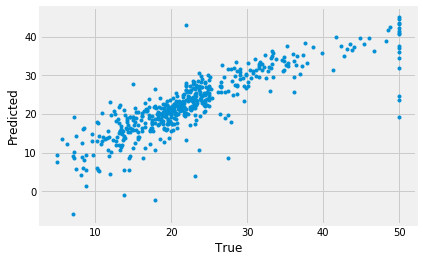

C:\Users\antho\Miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


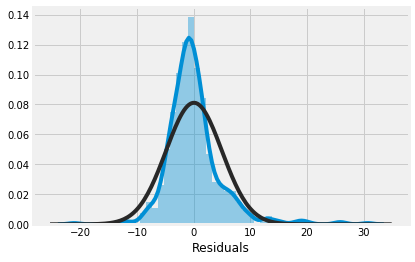

In [5]:
graph.plot(y, y_pred, '.')
graph.xlabel('True')
graph.ylabel('Predicted')
graph.show()

sns.distplot(y - y_pred, fit=stats.norm)
graph.xlabel('Residuals')
graph.show()

# Poisson Regression GLM

Problem is to predict...

$$N_{awards} \sim program + math$$

In [6]:
df = pd.read_csv('data/poisson_sim.csv')

# Preprocessing
df['program'] = df['prog'].map({1: 'general', 2: 'academic', 3: 'vocational'})
df = pd.concat([df, pd.get_dummies(df['program'])], axis='columns')

sns.countplot(df['num_awards'])
graph.show()

sns.countplot(df['program'])
graph.show()

display(df.head())

FileNotFoundError: File b'data/poisson_sim.csv' does not exist

In [ ]:
y = df['num_awards']
x = df[['math', 'academic', 'vocational']].copy()
x['neither'] = 1

In [ ]:
%%time
poisson_model = tfp.glm.Poisson()

results = tfp.glm.fit(tf.to_float(x.values), tf.to_float(y.values), model=poisson_model)

coef, y_pred, is_converged, n_iterations = results

In [ ]:
print(f'Is converged: {is_converged}')
print(f'N Iterations: {n_iterations}')
print('Coefs')
print(coef)

In [ ]:
graph.plot(y, np.exp(y_pred), '.')
graph.xlabel('True')
graph.ylabel('Predicted')
graph.show()

sns.distplot(y - np.exp(y_pred), fit=stats.norm)
graph.xlabel('Residuals')
graph.show()

# Markov Chain Monte Carlo in Tensorflow

It won't be as easy as PyMC3 but atleast I can anything.